# Natural Language Entity Extraction
**Extracting Ground Truth Labels from Radiology Reports**
<hr>
<img src="example-report.png" width="30%" align="right" style="padding-left:20px">

Here, we extract information from unstructured medical text.
- Extracting disease labels from clinical reports:
    - Text matching
    - Evaluating a labeler
    - Negation detection
    - Dependency parsing
- Question Answering with BERT:
    - Preprocessing text for input
    - Extracting answers from model output 

In [1]:
import nltk
import os
import re
import pickle
import bioc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel, TFAutoModelForQuestionAnswering, TFBertForQuestionAnswering
from text2bioc import *
from ptb2ud import Lemmatizer, NegBioPtb2DepConverter
from ssplit import NegBioSSplitter
import sklearn.metrics as metrics
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BITS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extracting Disease Labels from Clinical Reports: 

In [2]:
df = pd.read_csv('stanford_report_test.csv')
print('Dataset Size: {}'.format(df.shape))
df.head()

Dataset Size: (1000, 18)


,SimpleTestReportID,Report Impression,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Report Impression Parsed,Report Impression DG Paths
0,1.0,"\n \n1.mild pulmonary edema, and cardiomegaly....",NaN,NaN,1.0,NaN,NaN,1.0,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,['(S1 (S (S (S (LST (LS 1.)) (NP (JJ mild) (JJ...,['/data3/CXR-CHEST/dgs/GL66832b_GL6dd686/0.pkl...
1,2.0,\n \n1.unremarkable cardiomediastinal silhouet...,NaN,0.0,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,0.0,0.0,NaN,1.0,NaN,['(S1 (S (S (NP (LST (LS 1.)) (NN unremarkable...,['/data3/CXR-CHEST/dgs/GL6f51db_GL6f51dd/0.pkl...
2,3.0,\n1. lines and tubes are unchanged in position...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (NNS lines))...,['/data3/CXR-CHEST/dgs/GL666dde_GL6b021a/0.pkl...
3,4.0,\n1. postoperative portable film with a right-...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (JJ postoper...,['/data3/CXR-CHEST/dgs/GL6a8d08_GL6d5d21/0.pkl...
4,6.0,\n \n1.single frontal view of the chest demons...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,['(S1 (S (S (NP (NP (LST (LS 1.)) (JJ single) ...,['/data3/CXR-CHEST/dgs/GL675b56_GL6f4eb9/0.pkl...


The test set consists of 1,000 X-ray reports that have been manually labeled by a board certified radiologist for the presence or lack of presence of different pathologies. 
- You also have access to the extracted "Impression" section of each report which is the overall summary of the radiologists for each X-ray. 

### Cleaning the Dataset:

In [3]:
categories = ["Cardiomegaly", "Lung Lesion", "Airspace Opacity", "Edema", "Consolidation",
              "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
              "Pleural Other", "Fracture"]
df = df[['Report Impression'] + categories]
df = df.replace(1, True).fillna(False).replace(0, False).replace(-1, False)
print('Dataset Size: {}'.format(df.shape))
df.head()

Dataset Size: (1000, 12)


,Report Impression,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
0,"\n \n1.mild pulmonary edema, and cardiomegaly....",True,False,False,True,False,False,True,False,True,False,False
1,\n \n1.unremarkable cardiomediastinal silhouet...,False,False,True,False,False,False,False,False,False,False,True
2,\n1. lines and tubes are unchanged in position...,False,False,True,False,False,False,False,False,False,False,False
3,\n1. postoperative portable film with a right-...,False,False,True,True,False,False,True,True,False,False,False
4,\n \n1.single frontal view of the chest demons...,False,False,True,False,False,False,False,False,True,False,False


In [4]:
for i in range(3):
    print(f'Report Impression {i}:')
    print(df.loc[i, "Report Impression"])
    print('----------------------------------------------------------')

Report Impression 0:

 
1.mild pulmonary edema, and cardiomegaly.  trace pleural fluid 
effusions.
 
2.low lung volumes with minimal basilar atelectasis.
 
3.no new focal consolidation. 
 
4.interval placement of defibrillation pads.  
 

----------------------------------------------------------
Report Impression 1:

 
1.unremarkable cardiomediastinal silhouette
 
2.diffuse reticular pattern, which can be seen with an atypical 
infection or chronic fibrotic change.  no focal consolidation.
 
3.no pleural effusion or pneumothorax
 
4.mild degenerative changes in the lumbar spine and old right rib 
fractures. 
 

----------------------------------------------------------
Report Impression 2:

1. lines and tubes are unchanged in position.
2. increasing retrocardiac opacity and left midlung zone opacity.
3. there is a deep left costophrenic sulcus which is increased when
compared with prior films. no definite evidence of left
pneumothorax. clinical correlation is recommended. if clinicall

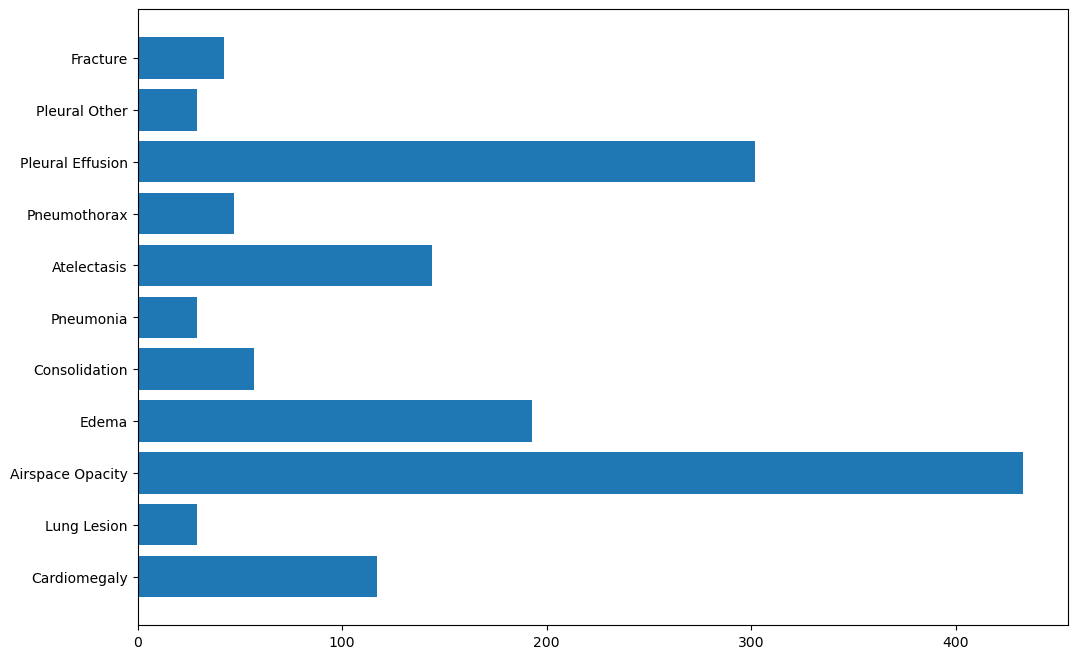

In [5]:
plt.figure(figsize = (12, 8))
plt.barh(y = categories, width = df[categories].sum(axis = 0))
plt.show()

We observe that pathologies like Airspace Opacity, Pleural Effusion, and Edema are present in many of the reports while Lung Lesion and Pneumonia are not as common in this dataset.

### Relevant Keywords:
Now, we'll prepare a function that will give out a list of relevant keywords for each pathology for us to use in detecting the presence of each label.  
**Example:** Relevant keywords for `Common Cold`: Acute Coryza, Acute Nasal Catarrh.

In [6]:
phrases_path = "NegBio/negbio/chexpert/phrases/"
def get_dict(path):
    label_to_mention = {}
    mention_files = os.listdir(path)

    for f in mention_files:
        with open(os.path.join(path, f)) as mention_file:
            condition = os.path.basename(f)[:-4]
            condition = condition.replace("_", " ").title()
            if condition not in label_to_mention:
                label_to_mention[condition] = []

            for line in mention_file:
                label_to_mention[condition].append(line.split("\n")[0])
    return label_to_mention

mentions = get_dict(phrases_path + "mention")
unmentions = get_dict(phrases_path + "unmention")

mentions_pk = "mentions.pkl"
unmentions_pk = "unmentions.pkl"
pickle.dump(mentions, open(mentions_pk, "wb"))
pickle.dump(unmentions, open(unmentions_pk, "wb"))

mentions = pickle.load(open(mentions_pk, "rb"))
unmentions = pickle.load(open(unmentions_pk, "rb"))

In [7]:
def get_mention_keywords(observation):
    if observation in mentions:
        return mentions[observation]
    else:
        return []

In [8]:
for cat in categories:
    related_keywords = get_mention_keywords(cat)
    print('Related Keywords for {} are: \n{}'.format(cat, ", ".join(related_keywords)))
    print('-------------------------------------------------------------')

Related Keywords for Cardiomegaly are: 
cardiomegaly, the heart, heart size, cardiac enlargement, cardiac size, cardiac shadow, cardiac contour, cardiac silhouette, enlarged heart
-------------------------------------------------------------
Related Keywords for Lung Lesion are: 
mass, nodular density, nodular densities, nodular opacity, nodular opacities, nodular opacification, nodule, lump, cavitary lesion, carcinoma, neoplasm, tumor
-------------------------------------------------------------
Related Keywords for Airspace Opacity are: 
opaci, decreased translucency, increased density, airspace disease, air-space disease, air space disease, infiltrate, infiltration, interstitial marking, interstitial pattern, interstitial lung, reticular pattern, reticular marking, reticulation, parenchymal scarring, peribronchial thickening, wall thickening, scar
-------------------------------------------------------------
Related Keywords for Edema are: 
edema, heart failure, chf, vascular conges

### Text CleanUp:
We create a function `clean`, which does basic text cleanup.
It converts pattern such as "and/or" to "or", replaces repeated whitespace with just one space, and removes redundant punctuation.

In [9]:
def clean(sentence):
    punctuation_spacer = str.maketrans({key: f"{key} " for key in '.,'})
    lower_sentence = sentence.lower()
    corrected_sentence = re.sub('and/or', 'or', lower_sentence)
    corrected_sentence = re.sub('(?<=[a-zA-Z])/(?=[a-zA-Z])', ' or ', corrected_sentence)
    clean_sentence = corrected_sentence.replace('..', '.')
    clean_sentence = clean_sentence.translate(punctuation_spacer)
    clean_sentence = ' '.join(clean_sentence.split())
    return clean_sentence

In [10]:
raw_text = df.loc[28, 'Report Impression']
print('Raw Text: \n' + raw_text)
print('Cleaned Text: \n' + clean(raw_text))

Raw Text: 

 
1.  bibasilar opacities, without significant change from the prior 
study, likely representing bilateral pleural effusions with 
atelectasis and/or pneumonia.
 
2.  interval decrease in focal opacification within the right upper 
lung.
 
3.  lines and tubes are unchanged. the distal tip of enteric tube 
remains coiled within the stomach.
 
 

Cleaned Text: 
1. bibasilar opacities, without significant change from the prior study, likely representing bilateral pleural effusions with atelectasis or pneumonia. 2. interval decrease in focal opacification within the right upper lung. 3. lines and tubes are unchanged. the distal tip of enteric tube remains coiled within the stomach.


### Get Labels:
We now create a function `get_labels` that can perform the following functions:
- It takes in a report (as an array of sentences)
- It returns a dictionary that maps each category to a boolean value, which indicates the presence or absence of the abnormality.
- Use a boolean "flag" to indicate whether a negation like "no" or "not" appears in a sentence.
- Only set a label to `True` if the word "not" or "no" did not appear in the sentence.

In [11]:
def get_labels(sentence_l):
    """
    Returns a dictionary that indicates presence of categories in
    sentences within the impression section of the report.
    Only set a label to True if no 'negative words' appeared in the sentence.
    hint: loop over the sentences array and use get_mention_keywords() function.
    
    Args: 
        sentence_l (array of strings): array of strings representing impression section
    Returns:
        observation_d (dict): dictionary mapping observation from CATEGORIES array to boolean value
    """
    # Notice that all of the negative words are written in lowercase
    negative_word_l = ["no", "not", "doesn't", "does not", "have not", "can not", "can't", "n't"]
    observation_d = {}
    
    # Initialize the observation dictionary 
    # so that all categories are not marked present.
    for cat in categories:
        
        # Initialize category to not present.
        observation_d[cat] = False

    # Loop through each sentence in the list of sentences
    for s in sentence_l:
        
        # make the sentence all lowercase
        s = s.lower()
        
        # Initialize the flag to indicate no negative mentions (yet)
        negative_flag = True
        
        # Go through all the negative words in the list
        for neg in negative_word_l:
            
            # Check if the word is a substring in the sentence
            if neg in s:
                # set the flag to indicate a negative mention
                negative_flag = False
                
                # Once a single negative mention is found,
                # you can stop checking the remaining negative words
                break

        # When a negative word was not found in the sentence,
        # check for the presence of the diseases
        if negative_flag != False:
            
            # Loop through the categories list
            for cat in categories:
                
                # Loop through each phrase that indicates this category
                for phrase in get_mention_keywords(cat):

                        # make the phrase all lowercase
                        phrase = phrase.lower()
                        
                        # Check if the phrase is a substring in the sentence
                        if phrase in s: 
                            
                            # Set the observation dictionary
                            # to indicate the presence of this category
                            observation_d[cat] = True
    
    return observation_d

In [12]:
test_sentences = ["Diffuse Reticular Pattern, which can be seen with an atypical infection or chronic fibrotic change.", 
                      "no Focal Consolidation."]
print('Raw Text:') 
for s in test_sentences:
    print(s)
print('')
data = get_labels(test_sentences)
print("Retrieved Labels:") 
for key, value in data.items():
    print(f'{key}: {value}')

Raw Text:
Diffuse Reticular Pattern, which can be seen with an atypical infection or chronic fibrotic change.
no Focal Consolidation.

Retrieved Labels:
Cardiomegaly: False
Lung Lesion: False
Airspace Opacity: True
Edema: False
Consolidation: False
Pneumonia: True
Atelectasis: False
Pneumothorax: False
Pleural Effusion: False
Pleural Other: False
Fracture: False


### Evaluate the Performance of the Function on the Dataset:
In order to evaluate the performance of the labeler, we'll use a metric called the [F1 score](https://en.wikipedia.org/wiki/F1_score). 
- The F1 score is the harmonic mean of precision and recall. 
- This score is a common metric that is used in information retrieval problems. 

The reason that we care both about precision and recall is that only a small subset of the labels for each report are positive and the rest are negative. 
- So a traditional metric such as accuracy could be very high if you just report every label as False. 
- Precision and recall (summarized in the F1 score) help you measure your classification's performance for both positive cases as well as negative cases.

$$F_1 = \left( \frac{2}{ \frac{1}{recall} + \frac{1}{precision} }\right) = 2 \times \frac{precision \times recall}{precision + recall}$$

In [13]:
def get_bioc_collection(df):
    # Initialize a BioC collection
    collection = bioc.BioCCollection()

    # Create an instance of the NegBioSSplitter class
    splitter = NegBioSSplitter()

    # Iterate through each row of the DataFrame
    for i, report in enumerate(df["Report Impression"]):
        # Convert the report content into a BioC document
        document = text2document(str(i), report)

        # Apply the sentence splitter to the BioC document
        document = splitter.split_doc(document)

        # Add the processed BioC document to the BioC collection
        collection.add_document(document)

    # Return the BioC collection containing the processed documents
    return collection

In [14]:
def get_preds(classification_function, df, cleanup=False):
    # Generate BioC collection from the DataFrame
    collection = get_bioc_collection(df)
    # Get the list of documents from the BioC collection
    docs = collection.documents
    # Initialize an empty DataFrame to store predictions
    pred_frame = pd.DataFrame()

    # Iterate through each document in the BioC collection
    for i, doc in enumerate(docs):
        # Extract sentences from the document
        sentences_array = [s.text for s in doc.passages[0].sentences]

        # Optionally clean up sentences using a cleanup option
        if cleanup:
            sentences_array = [clean(s) for s in sentences_array]

        # Apply the classification function to get predictions for each sentence
        preds = classification_function(sentences_array)

        # Convert the dictionary to a DataFrame
        preds_df = pd.DataFrame.from_dict(preds, orient='index').transpose()

        # Append the predictions to the DataFrame
        pred_frame = pd.concat([pred_frame, preds_df], ignore_index=True)

    # Convert the DataFrame to boolean type
    return pred_frame.astype("bool")

In [15]:
def calculate_f1(df, pred_frame):
    # Initialize an empty list to store F1 scores
    results_list = []

    # Iterate through each category (label) in categories
    for cat in categories:
        # Get the ground truth (actual labels) for the current category
        gt = df[cat]
        # Get the predicted labels for the current category
        pred = pred_frame[cat]
        # Calculate the F1 score for the current category
        f1 = metrics.f1_score(gt, pred)
        # Append the category and its corresponding F1 score to the results list
        results_list.append({"Label": cat, "F1": round(f1, 3)})

    # Calculate and append the average F1 score across all categories to the results list
    avg_f1 = round(pd.DataFrame(results_list)["F1"].mean(), 3)
    results_list.append({"Label": "Average", "F1": avg_f1})

    # Convert the list of dictionaries to a DataFrame
    results = pd.DataFrame(results_list)

    # Return the results DataFrame with columns "Label" and "F1"
    return results[["Label", "F1"]]

In [16]:
def get_f1_table(classfication_function, df, cleanup=False):
    pred_frame = get_preds(classfication_function, df, cleanup=cleanup)
    
    # calculate F1
    return calculate_f1(df, pred_frame)

**Without Cleaning the Text:**

In [17]:
get_f1_table(get_labels, df, cleanup = False)

,Label,F1
0,Cardiomegaly,0.793
1,Lung Lesion,0.465
2,Airspace Opacity,0.905
3,Edema,0.797
4,Consolidation,0.424
5,Pneumonia,0.463
6,Atelectasis,0.642
7,Pneumothorax,0.656
8,Pleural Effusion,0.859
9,Pleural Other,0.607


**After Cleaning the Text:**

In [18]:
get_f1_table(get_labels, df, cleanup = True)

,Label,F1
0,Cardiomegaly,0.807
1,Lung Lesion,0.465
2,Airspace Opacity,0.905
3,Edema,0.795
4,Consolidation,0.424
5,Pneumonia,0.463
6,Atelectasis,0.642
7,Pneumothorax,0.656
8,Pleural Effusion,0.859
9,Pleural Other,0.621


In [19]:
basic = get_f1_table(get_labels, df, cleanup = False).rename(columns = {"F1": "F1 Without Cleaning"})
clean_basic = get_f1_table(get_labels, df, cleanup = True).rename(columns = {"F1": "F1 After Cleaning"})
joined_preds = basic.merge(clean_basic, on="Label")
joined_preds

,Label,F1 Without Cleaning,F1 After Cleaning
0,Cardiomegaly,0.793,0.807
1,Lung Lesion,0.465,0.465
2,Airspace Opacity,0.905,0.905
3,Edema,0.797,0.795
4,Consolidation,0.424,0.424
5,Pneumonia,0.463,0.463
6,Atelectasis,0.642,0.642
7,Pneumothorax,0.656,0.656
8,Pleural Effusion,0.859,0.859
9,Pleural Other,0.607,0.621


## Question Answering with BERT:

In the previous section, you looked at extracting disease labels from radiology reports. That could use a rule-based system because you asked a limited kind of question: "Is the disease present?".

What if you want to support any question a physician might want to ask? To do this, we'll have to use more recent artificial intelligence techniques and large datasets. 
- In this section, we'll walk through the pre- & post-processing involved in applying [BERT](https://github.com/google-research/bert) to the problem of question answering. 
- After developing this infrastructure, we'll use the model to answer questions from clinical notes. 

Implementing question answering can take a few steps, even using pretrained models. 
- First retrieve our model and tokenizer. The tokenizer prepares the input, mapping each word to a unique element in the vocabulary and inserting special tokens. 
- Then the model processes these tokenized inputs to create valuable embeddings and performs tasks such as question answering.

**Load The Tokenizer:**

In [20]:
tokenizer = AutoTokenizer.from_pretrained("./models")

### Preparing the Input:
Our first task will be to prepare the raw passage & question for input into the model. 

Given the strings `p` and `q`, you want to turn them into an input of the following form: 

`[CLS]` `[q_token1]`, `[q_token2]`, ..., `[SEP]` `[p_token1]`, `[p_token2]`, ...

Here, the special characters `[CLS]` and `[SEP]` let the model know which part of the input is the question and which is the answer. 
- The question appears between `[CLS]` and `[SEP]`.
- The answer appears after `[SEP]`

We'll also pad the input to the maximum input length, since BERT takes in a fixed-length input.

We create the function to prepare input to BERT. The function will return three items. 
- First is `input_ids`, which holds the numerical ids of each token. 
- Second, you'll output the `input_mask`, which has 1's in parts of the input tensor representing input tokens, and 0's where there is padding. 
- Finally, you'll output `tokens`, the output of the tokenizer (including the `[CLS]` and `[SEP]` tokens).

In [21]:
def prepare_bert_input(question, passage, tokenizer, max_seq_length=384):
    """
    Prepare question and passage for input to BERT. 

    Args:
        question (string): question string
        passage (string): passage string where answer should lie
        tokenizer (Tokenizer): used for transforming raw string input
        max_seq_length (int): length of BERT input
    
    Returns:
        input_ids (tf.Tensor): tensor of size (1, max_seq_length) which holds
                               ids of tokens in input
        input_mask (list): list of length max_seq_length of 1s and 0s with 1s
                           in indices corresponding to input tokens, 0s in
                           indices corresponding to padding
        tokens (list): list of length of actual string tokens corresponding to input_ids
    """
    # tokenize question
    question_tokens = tokenizer.tokenize(question)
    
    # tokenize passage
    passage_token = tokenizer.tokenize(passage)

    # get special tokens 
    CLS = tokenizer.cls_token
    SEP = tokenizer.sep_token
    
    # manipulate tokens to get input in correct form (not adding padding yet)
    # CLS {question_tokens} SEP {answer_tokens} 
    # This should be a list of tokens
    tokens = [CLS] + question_tokens + [SEP] + passage_token
    
    # Convert tokens into integer IDs. Use `tokenizer.convert_tokens_to_ids`
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Create an input mask which has integer 1 for each token in the 'tokens' list
    input_mask = [1]*len(input_ids)

    # pad input_ids with 0s until it is the max_seq_length
    # Create padding for input_ids by creating a list of zeros [0,0,...0]
    # Add the padding to input_ids so that its length equals max_seq_length
    input_ids = input_ids + [0]*(max_seq_length - len(input_ids))
    
    # Do the same to pad the input_mask so its length is max_seq_length
    input_mask = input_mask + [0]*(max_seq_length - len(input_mask))

    return tf.expand_dims(tf.convert_to_tensor(input_ids), 0), input_mask, tokens 

### Getting Answer from Model Output:
After taking in the tokenized input, the model outputs two vectors. 
- The first vector contains the scores (more formally, logits) for the starting index of the answer. 
    - A higher score means that index is more likely to be the start of the answer span in the passage. 
- The second vector contains the score for the end index of the answer. 

We want to output the span that maximizes the start score and end score. 
- To be valid, the start index has to occur before the end index. Formally, you want to find:

$$\arg\max_{i <= j, mask_i=1, mask_j = 1} start\_scores[i] + end\_scores[j]$$

- In words, this formulas is saying, calculate the sum and start scores of start position 'i' and end position 'j', given the constraint that the start 'i' is either before or at the end position 'j'; then find the positions 'i' and 'j' where this sum is the highest.
- Furthermore, you want to make sure that $i$ and $j$ are in the relevant parts of the input (i.e. where `input_mask` equals 1.)

In [22]:
def get_span_from_scores(start_scores, end_scores, input_mask, verbose=False):
    """
    Find start and end indices that maximize sum of start score
    and end score, subject to the constraint that start is before end
    and both are valid according to input_mask.

    Args:
        start_scores (list): contains scores for start positions, shape (1, n)
        end_scores (list): constains scores for end positions, shape (1, n)
        input_mask (list): 1 for valid positions and 0 otherwise
    """
    n = len(start_scores)
    max_start_i = -1
    max_end_j = -1
    max_start_val = -np.inf
    max_end_val = -np.inf
    max_sum = -np.inf
    
    # Find i and j that maximizes start_scores[i] + end_scores[j]
    # so that i <= j and input_mask[i] == input_mask[j] == 1
    
    # set the range for i
    for i in range(n): 
        
        # set the range for j
        for j in range(i, n): 

            # both input masks should be 1
            if (input_mask[i] == 1) & (input_mask[j] == 1): 
                
                # check if the sum of the start and end scores is greater 
                # than the previous max sum
                if (start_scores[i] + end_scores[j]) > max_sum: 

                    # calculate the new max sum
                    max_sum = start_scores[i] + end_scores[j]
        
                    # save the index of the max start score
                    max_start_i = i
                
                    # save the index for the max end score
                    max_end_j = j
                    
                    # save the value of the max start score
                    max_start_val = start_scores[i]
                    
                    # save the value of the max end score
                    max_end_val = end_scores[j]
    return max_start_i, max_end_j

Finally, we'll add some post-processing to get the final string.

In [23]:
def construct_answer(tokens):
    """
    Combine tokens into a string, remove some hash symbols, and leading/
    trailing whitespace.
    Args:
        tokens: a list of tokens (strings)
    
    Returns:
        out_string: the processed string.
    """
    
    # join the tokens together with whitespace
    out_string = ' '.join(tokens)
    
    # replace ' ##' with empty string
    out_string = out_string.replace(' ##', '')
    
    # remove leading and trailing whitespace
    out_string = out_string.strip()
  
    # if there is an '@' symbol in the tokens, remove all whitespace
    if '@' in tokens:
        out_string = out_string.replace(' ', '')

    return out_string

In [24]:
model = TFAutoModelForQuestionAnswering.from_pretrained('./models')

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at ./models.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


### Putting It All Together:

In [25]:
def get_model_answer(model, question, passage, tokenizer, max_seq_length=384):
    """
    Identify answer in passage for a given question using BERT. 

    Args:
        model (Model): pretrained Bert model which we'll use to answer questions
        question (string): question string
        passage (string): passage string
        tokenizer (Tokenizer): used for preprocessing of input
        max_seq_length (int): length of input for model
        
    Returns:
        answer (string): answer to input question according to model
    """ 
    # prepare input: use the function prepare_bert_input
    input_ids, input_mask, tokens = prepare_bert_input(question, passage, tokenizer, max_seq_length)
    
    # get scores for start of answer and end of answer
    # use the model returned by TFAutoModelForQuestionAnswering.from_pretrained("./models")
    # pass in in the input ids that are returned by prepare_bert_input
    start_scores = model(input_ids).start_logits.numpy()
    end_scores = model(input_ids).end_logits.numpy()
    
    # start_scores and end_scores will be tensors of shape [1,max_seq_length]
    # To pass these into get_span_from_scores function, 
    # take the value at index 0 to get a tensor of shape [max_seq_length]
    start_scores = start_scores[0]
    end_scores = end_scores[0]
    
    # using scores, get most likely answer
    # use the get_span_from_scores function
    span_start, span_end = get_span_from_scores(start_scores, end_scores, input_mask)
    
    # Using array indexing to get the tokens from the span start to span end (including the span_end)
    answer_tokens = tokens[span_start:span_end + 1]
    
    # Combine the tokens into a single string and perform post-processing
    # use construct_answer
    answer = construct_answer(answer_tokens)
    
    return answer

### Applying The Functions:

In [26]:
passage = "Computational complexity theory is a branch of the theory \
           of computation in theoretical computer science that focuses \
           on classifying computational problems according to their inherent \
           difficulty, and relating those classes to each other. A computational \
           problem is understood to be a task that is in principle amenable to \
           being solved by a computer, which is equivalent to stating that the \
           problem may be solved by mechanical application of mathematical steps, \
           such as an algorithm."

question = "What branch of theoretical computer science deals with broadly \
            classifying computational problems by difficulty and class of relationship?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected Answer: Computational complexity theory")

Output: Computational complexity theory
Expected Answer: Computational complexity theory


In [27]:
passage = "The word pharmacy is derived from its root word pharma which was a term used since \
           the 15th–17th centuries. However, the original Greek roots from pharmakos imply sorcery \
           or even poison. In addition to pharma responsibilities, the pharma offered general medical \
           advice and a range of services that are now performed solely by other specialist practitioners, \
           such as surgery and midwifery. The pharma (as it was referred to) often operated through a \
           retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines. \
           Often the place that did this was called an apothecary and several languages have this as the \
           dominant term, though their practices are more akin to a modern pharmacy, in English the term \
           apothecary would today be seen as outdated or only approproriate if herbal remedies were on offer \
           to a large extent. The pharmas also used many other herbs not listed. The Greek word Pharmakeia \
           (Greek: φαρμακεία) derives from pharmakon (φάρμακον), meaning 'drug', 'medicine' (or 'poison')."

question = "What word is the word pharmacy taken from?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected Answer: pharma")

Output: pharma
Expected Answer: pharma


**Let's try it on clinical notes.**

In [28]:
passage = "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, \
           and valvular insufficiency. The patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain \
           and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. \
           During the hospitalization, the patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. This consultation is for further evaluation in this regard. As per the patient, \
           she is an 86-year-old female, has limited activity level. She has been having shortness of breath \
           for many years. She also was told that she has a heart murmur, which was not followed through \
           on a regular basis."

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "What does her echocardiogram show?"
q5 = "What other symptoms does the patient have?"


questions = [q1, q2, q3, q4, q5]

for i, q in enumerate(questions):
    print("Question {}: {}".format(i+1, q))
    print()
    print("Answer: {}".format(get_model_answer(model, q, passage, tokenizer)))
    print()
    print('------------------------------------------------------')

Question 1: How old is the patient?

Answer: 86

------------------------------------------------------
Question 2: Does the patient have any complaints?

Answer: The patient complains of shortness of breath

------------------------------------------------------
Question 3: What is the reason for this consultation?

Answer: further evaluation

------------------------------------------------------
Question 4: What does her echocardiogram show?

Answer: severe mitral regurgitation and also large pleural effusion

------------------------------------------------------
Question 5: What other symptoms does the patient have?

Answer: colitis and also diverticulitis

------------------------------------------------------


To improve performance, we need to ideally collect a medical Q&A dataset & fine-tune the model. But even without fine-tuning, the model is able to reasonably answer most of the questions.